# Exploratory Data Analysis for Post-Covid Mass Transit

### Question:

As New York City slowly resumes normal life and people return to work, the Metropolitan Transit Agency is tasked with keeping riders safe. Overcrowding on subways will continue to present a health risk to riders unless addressed creatively. The MTA wants to understand where ridership is highest and growing the fastest in order to keep the public safe.

This information can inform plans to deploy more buses in hot spots and invest in alternate transit options, such as creating more busways and bike lanes, to relieve overcrowding. In order for mass transit to persist, riders must view it as safe; this analysis represents a preliminary step toward reaching that goal.

### Data Description:

I'm looking at the [MTA's weekly turnstile](http://web.mta.info/developers/turnstile.html) CSVs. Each row contains a count of the number of the people who swiped through, or exited, a given turnstile within a four hour interval. So, it's possible to observe the flow of passengers throughout the day.

I am also using [MTA's Stations location data](https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49) which maps stations to their latitude/longitudes for geospatial visualization, and [NYC borough maps](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm) data to map my findings. 

Thanks to [this guy](https://q-shick.github.io/portfolio/proj_mta_nyc.html) for the inspiration.

## Loading the Data
Let's import the libraries we'll use.

In [1]:
# database
from sqlalchemy import create_engine
from sqlalchemy import inspect

# data processing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import timedelta

# geographical data
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import shapefile
from shapely.geometry import Point # Point class
from shapely.geometry import shape # shape() is a function to convert geo objects through the interface

# visualization
from IPython.display import IFrame
import seaborn as sns
sns.set(font_scale=1.1)
import plotly.express as px

We query in MTA data from 2021.

In [2]:
engine = create_engine('sqlite:///mta_data.db')
insp = inspect(engine)
print(insp.get_table_names())

['mta_data']


In [3]:
mta_data = pd.read_sql('SELECT * FROM mta_data WHERE date LIKE \'%21\';', engine)

Let's get a sense of how our data is structured:

In [4]:
mta_data.head()

C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  00:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  16:00:00   

      DESC  ENTRIES    EXITS  
0  REGULAR  7581941  2591624  
1  REGULAR  7581950  2591625  
2  REGULAR  7581954  2591635  
3  REGULAR  7582009  2591655  
4  REGULAR  7582124  2591683

In [5]:
mta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5679771 entries, 0 to 5679770
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 476.7+ MB


In [6]:
# Checking for null values.
mta_data.isna().sum()

# transform column names to lower case
mta_data.columns= mta_data.columns.str.lower()

# create datetime object, for easy calculations and visualization
mta_data['date_time'] = pd.to_datetime(mta_data['date'] + ' ' + mta_data['time'], infer_datetime_format=True)
print('Timestamps range from ', mta_data['date_time'].min(), 'to ',  mta_data['date_time'].max())

Timestamps range from  2021-01-01 00:00:00 to  2021-06-18 23:59:20


## Cleaning the Data
### Deleting Duplicate Data

Now let's run some diagnostics on the data and clean it. We can isolate specific turnstiles by creating boolean series masks, then use them to index into the dataframe: 

In [7]:
# Honing in one one specific turnstile
mask = ((mta_data["c/a"] == "A002") &
        (mta_data["unit"] == "R051") & 
        (mta_data["scp"] == "02-00-00") & 
        (mta_data["station"] == "59 ST"))

mta_data[mask].head(6)

c/a  unit       scp station linename division        date      time  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  00:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  16:00:00   
5  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  20:00:00   

      desc  entries    exits           date_time  
0  REGULAR  7581941  2591624 2021-06-05 00:00:00  
1  REGULAR  7581950  2591625 2021-06-05 04:00:00  
2  REGULAR  7581954  2591635 2021-06-05 08:00:00  
3  REGULAR  7582009  2591655 2021-06-05 12:00:00  
4  REGULAR  7582124  2591683 2021-06-05 16:00:00  
5  REGULAR  7582248  2591700 2021-06-05 20:00:00

In [8]:
# Sanity check to verify that "c/a", "unit", "scp", "station", "date_time" is unique
mta_data[mta_data.duplicated(keep='first')].head()

c/a  unit       scp station linename division        date      time  \
209506  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  00:00:00   
209507  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  04:00:00   
209508  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  08:00:00   
209509  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  12:00:00   
209510  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/05/2021  16:00:00   

           desc  entries    exits           date_time  
209506  REGULAR  7581941  2591624 2021-06-05 00:00:00  
209507  REGULAR  7581950  2591625 2021-06-05 04:00:00  
209508  REGULAR  7581954  2591635 2021-06-05 08:00:00  
209509  REGULAR  7582009  2591655 2021-06-05 12:00:00  
209510  REGULAR  7582124  2591683 2021-06-05 16:00:00

In [9]:
# Dropping duplicate data
mta_data.sort_values(["c/a", "unit", "scp", "station", "date_time"], 
                          inplace=True, ascending=True)
mta_data.drop_duplicates(subset=["c/a", "unit", "scp", "station", "date_time"], inplace=True)
mta_data.drop(["desc"], axis=1, errors="ignore", inplace=True)
mta_data.head()

c/a  unit       scp station linename division        date      time  \
5020778  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  03:00:00   
5020779  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  07:00:00   
5020780  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  11:00:00   
5020781  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  15:00:00   
5020782  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  19:00:00   

         entries    exits           date_time  
5020778  7511448  2558786 2021-01-01 03:00:00  
5020779  7511451  2558789 2021-01-01 07:00:00  
5020780  7511461  2558813 2021-01-01 11:00:00  
5020781  7511495  2558831 2021-01-01 15:00:00  
5020782  7511620  2558857 2021-01-01 19:00:00

Success! We have removed all duplicate data.

### Calculating Daily Entries per Turnstile

Each combination of `C/A`, `UNIT`, `SCP`, and `STATION` represents a unique turnstile. Let's take a look at a specific turnstile on a specific date.

Looks like each row represents a turnstile (identified by a combination of  the `C/A`, `UNIT`, `SCP`, and `STATION` columns) at a specific time -- approximately four hours apart. The `ENTRIES` column represents **cumulative entries** at that point in time.

In [10]:
# Honing in one one specific turnstile for one specific day
mta_data[(mta_data["c/a"] == "A002") & 
(mta_data["unit"] == "R051") & 
(mta_data["scp"] == "02-00-00") & 
(mta_data["station"] == "59 ST") &
(mta_data["date"] == "01/01/2021")]

c/a  unit       scp station linename division        date      time  \
5020778  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  03:00:00   
5020779  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  07:00:00   
5020780  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  11:00:00   
5020781  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  15:00:00   
5020782  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  19:00:00   
5020783  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  23:00:00   

         entries    exits           date_time  
5020778  7511448  2558786 2021-01-01 03:00:00  
5020779  7511451  2558789 2021-01-01 07:00:00  
5020780  7511461  2558813 2021-01-01 11:00:00  
5020781  7511495  2558831 2021-01-01 15:00:00  
5020782  7511620  2558857 2021-01-01 19:00:00  
5020783  7511647  2558865 2021-01-01 23:00:00

In [11]:
turnstiles_daily = (mta_data
                        .groupby(["c/a", "unit", "scp", "station", "date"],as_index=False)
                        [['entries', 'exits']].max())
turnstiles_daily.head()

c/a  unit       scp station        date  entries    exits
0  A002  R051  02-00-00   59 ST  01/01/2021  7511647  2558865
1  A002  R051  02-00-00   59 ST  01/02/2021  7511996  2559007
2  A002  R051  02-00-00   59 ST  01/03/2021  7512214  2559091
3  A002  R051  02-00-00   59 ST  01/04/2021  7512754  2559328
4  A002  R051  02-00-00   59 ST  01/05/2021  7513300  2559580

Now we have daily data for each individual turnsite. However, the `entries` column still signifies *cumulative* entries. We would like to calculate daily entries. 

In [12]:
# Create new column with previous day's entries and exits 
turnstiles_daily["previous_entries"] = turnstiles_daily.groupby(['c/a', 'unit', 'station', 'scp'])['entries'].shift(1)
turnstiles_daily["previous_exits"] = turnstiles_daily.groupby(['c/a', 'unit', 'station', 'scp'])['exits'].shift(1)

# Drop first date instance of each turnstile, which get NaN for previous day's entries and exits
turnstiles_daily.dropna(subset=['previous_entries', 'previous_exits'], axis=0, inplace=True)

# Convert entry/exit columns to integers
turnstiles_daily = turnstiles_daily.astype({'previous_entries': 'int32', 'entries': 'int32', 'exits':'int32', 'previous_exits': 'int32', })
turnstiles_daily

c/a  unit       scp        station        date  entries    exits  \
1        A002  R051  02-00-00          59 ST  01/02/2021  7511996  2559007   
2        A002  R051  02-00-00          59 ST  01/03/2021  7512214  2559091   
3        A002  R051  02-00-00          59 ST  01/04/2021  7512754  2559328   
4        A002  R051  02-00-00          59 ST  01/05/2021  7513300  2559580   
5        A002  R051  02-00-00          59 ST  01/06/2021  7513790  2559817   
...       ...   ...       ...            ...         ...      ...      ...   
843357  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/14/2021     5554      584   
843358  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/15/2021     5554      584   
843359  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/16/2021     5554      584   
843360  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/17/2021     5554      584   
843361  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/18/2021     5554      584   

        previous_entries  previous_exits  
1                7511647         2558865  
2                7511996         2559007  
3                7512214         2559091  
4                7512754         2559328  
5                7513300         2559580  
...                  ...             ...  
843357              5554             584  
843358              5554             584  
843359              5554             584  
843360              5554             584  
843361              5554             584  

[838300 rows x 9 columns]

**Sanity Check**. We should expect *positive* daily entries, and nothing drastically large.

In [13]:
(turnstiles_daily["entries"] - turnstiles_daily["previous_entries"]).describe()

count    8.383000e+05
mean    -2.813440e+03
std      5.070132e+06
min     -1.604323e+09
25%      5.600000e+01
50%      2.070000e+02
75%      4.320000e+02
max      2.139011e+09
dtype: float64

A few things are happening:

- We have negative values.
- Some values are way too big (see the difference between the max and the 75% percentile).

We can address these all at once.

In [14]:
# How many rows are backwards
turnstiles_daily[turnstiles_daily["entries"] < turnstiles_daily["previous_entries"]].shape

(7727, 9)

In [15]:
turnstiles_daily[turnstiles_daily["entries"] < turnstiles_daily["previous_entries"]].head()

c/a  unit       scp     station        date    entries      exits  \
757   A002  R051  02-03-02       59 ST  03/23/2021        668        701   
6590  A011  R080  01-03-00  57 ST-7 AV  01/02/2021  885629550  489699496   
6591  A011  R080  01-03-00  57 ST-7 AV  01/03/2021  885629423  489698928   
6592  A011  R080  01-03-00  57 ST-7 AV  01/04/2021  885629327  489698557   
6593  A011  R080  01-03-00  57 ST-7 AV  01/05/2021  885629131  489697857   

      previous_entries  previous_exits  
757            6641481         8869858  
6590         885629636       489699868  
6591         885629550       489699496  
6592         885629423       489698928  
6593         885629327       489698557

### Handling Reverse Entries/Exits Counters

We notice two irregularities at play here. 

- The first row points to a reset in a turnstile's counter -- once it reached a maximum value, the machine reset to zero. 
- The subsequent rows show a turnstile whose counter is actually monotonically decreasing. The most likely explanation is this turnstile is counting backwards. 

Let's investigate the turnstile counting in reverse order first. 

In [16]:
# What's the deal with counter being in reverse
mask = ((mta_data["c/a"] == "A011") & 
(mta_data["unit"] == "R080") & 
(mta_data["scp"] == "01-03-00") & 
(mta_data["station"] == "57 ST-7 AV") &
(mta_data["date"] == '01/05/2021'))

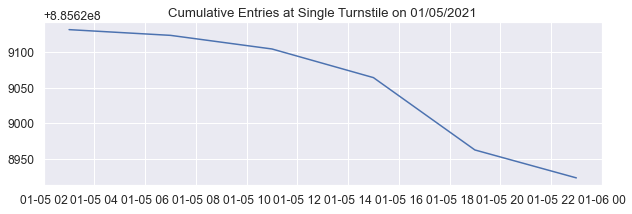

In [17]:
reverse = mta_data[mask].sort_values('date_time')[['date', 'time', 'entries', 'exits', 'date_time']]

plt.figure(figsize=(10,3))
plt.plot(reverse['date_time'], reverse['entries'])
plt.title('Cumulative Entries at Single Turnstile on 01/05/2021');

In [18]:
# Let's see how many stations have this problem
(turnstiles_daily[turnstiles_daily["entries"] < turnstiles_daily["previous_entries"]]
    .groupby(["c/a", "unit", "scp", "station"])
    .size())

c/a    unit  scp       station        
A002   R051  02-03-02  59 ST                1
A011   R080  01-03-00  57 ST-7 AV         168
             01-03-01  57 ST-7 AV           1
             01-03-03  57 ST-7 AV           1
             01-03-04  57 ST-7 AV           1
                                         ... 
R624   R124  00-00-02  KINGSTON AV          1
R627   R063  00-03-02  SUTTER AV-RUTLD      1
R730   R431  00-00-04  EASTCHSTER/DYRE    166
S101   R070  00-00-04  ST. GEORGE           1
TRAM2  R469  00-05-00  RIT-ROOSEVELT        1
Length: 332, dtype: int64

In [19]:
def get_daily_entry_counts(row, max_counter):
    counter = row["entries"] - row["previous_entries"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        print(f'entries: {row["entries"]} <-- {row["previous_entries"]}')
        counter = min(row["entries"], row["previous_entries"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

turnstiles_daily["daily_entries"] = turnstiles_daily.apply(get_daily_entry_counts, axis=1, max_counter=10000)

entries: 668 <-- 6641481
entries: 262144 <-- 0
entries: 52806 <-- 17116894
entries: 121 <-- 154694
entries: 3109 <-- 1390173
entries: 160 <-- 479907
entries: 205 <-- 4341004
entries: 117 <-- 11715665
entries: 198 <-- 5102094
entries: 2403 <-- 18398491
entries: 134 <-- 11416
entries: 205 <-- 196944
entries: 327760 <-- 185586911
entries: 262161 <-- 337910
entries: 2469 <-- 986428
entries: 180 <-- 13125
entries: 262144 <-- 1
entries: 375 <-- 2172459
entries: 14 <-- 1028362
entries: 182 <-- 765804
entries: 196770 <-- 13806
entries: 18182709 <-- 5119680
entries: 5120968 <-- 18182709
entries: 9728986 <-- 1159430
entries: 1160101 <-- 9728986
entries: 56092 <-- 41866
entries: 41866 <-- 56092
entries: 1400021 <-- 46231
entries: 46231 <-- 1400021
entries: 157 <-- 247996
entries: 262150 <-- 459006
entries: 408 <-- 1657112
entries: 327866 <-- 756269765
entries: 1132 <-- 328024
entries: 262152 <-- 553649999
entries: 27 <-- 262152
entries: 262152 <-- 229572623
entries: 0 <-- 5309746
entries: 262145 

entries: 97 <-- 61476
entries: 367 <-- 4002020
entries: 786480 <-- 20804
entries: 269 <-- 2320052
entries: 726 <-- 681845
entries: 1437 <-- 952442
entries: 262144 <-- 1557
entries: 834 <-- 935412
entries: 234 <-- 25100
entries: 103 <-- 1380718
entries: 393952 <-- 104111192
entries: 767 <-- 394109
entries: 303 <-- 37239
entries: 779 <-- 2844722
entries: 1940 <-- 315605669
entries: 358 <-- 65004
entries: 430 <-- 14282
entries: 10014605 <-- 9293579
entries: 27 <-- 181453
entries: 684 <-- 261148
entries: 852524 <-- 2830560
entries: 688 <-- 141769497
entries: 262144 <-- 143
entries: 67926 <-- 17651026
entries: 602 <-- 4470923
entries: 70 <-- 30154514
entries: 811 <-- 291977
entries: 44861 <-- 12471
entries: 1040213826 <-- 4086923
entries: 151200964 <-- 50928236
entries: 738431481 <-- 53263405
entries: 53237646 <-- 738434642
entries: 262144 <-- 459511
entries: 73220686 <-- 1560551488
entries: 55643 <-- 8662
entries: 262144 <-- 786432
entries: 146669646 <-- 1123536132
entries: 1191143076 <-- 

In [20]:
turnstiles_daily.head()

c/a  unit       scp station        date  entries    exits  \
1  A002  R051  02-00-00   59 ST  01/02/2021  7511996  2559007   
2  A002  R051  02-00-00   59 ST  01/03/2021  7512214  2559091   
3  A002  R051  02-00-00   59 ST  01/04/2021  7512754  2559328   
4  A002  R051  02-00-00   59 ST  01/05/2021  7513300  2559580   
5  A002  R051  02-00-00   59 ST  01/06/2021  7513790  2559817   

   previous_entries  previous_exits  daily_entries  
1           7511647         2558865            349  
2           7511996         2559007            218  
3           7512214         2559091            540  
4           7512754         2559328            546  
5           7513300         2559580            490

In [21]:
turnstiles_daily['daily_entries'].describe()

count    838300.000000
mean        302.270457
std         324.045441
min           0.000000
25%          60.000000
50%         211.000000
75%         438.000000
max        9681.000000
Name: daily_entries, dtype: float64

In [22]:
def get_daily_exit_counts(row, max_counter):
    counter = row["exits"] - row["previous_exits"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        # print(f'exits: {row["exits"]} <-- {row["previous_exits"]}') # prints converted values
        counter = min(row["exits"], row["previous_exits"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

In [23]:
turnstiles_daily["daily_exits"] = turnstiles_daily.apply(get_daily_exit_counts, axis=1, max_counter=10000)

In [24]:
turnstiles_daily['daily_exits'].describe()

count    838300.000000
mean        327.973473
std         400.612256
min           0.000000
25%          57.000000
50%         196.000000
75%         452.000000
max        9823.000000
Name: daily_exits, dtype: float64

Our datafame now includes reasonable counts for daily entries and exits. 

In [25]:
turnstiles_daily.sample(5)

c/a  unit       scp          station        date   entries     exits  \
101206  C028  R216  01-05-00  BAY RIDGE-95 ST  05/14/2021      1330         0   
460087  N606  R025  00-05-01   JAMAICA CENTER  04/06/2021         0      1463   
271832  N118  R199  01-00-01  KINGSTON-THROOP  03/27/2021      7259     24640   
530266  R103  R304  00-00-00        RECTOR ST  02/04/2021    950766     33149   
678356  R251  R144  00-00-00            96 ST  02/16/2021  24072940  15915665   

        previous_entries  previous_exits  daily_entries  daily_exits  
101206              1330               0              0            0  
460087                 0            1463              0            0  
271832              7147           24203            112          437  
530266            950491           33138            275           11  
678356          24071819        15914398           1121         1267

## Processing Daily Activity at the Station Level 

So far we have been working with individual turnstiles, but we would like to do calculations at the station level. So, now, we will come up with a **daily** time series *for each STATION*, by adding up the daily entries and exits for all the turnstiles in each individual station.


In [26]:
stations_daily = turnstiles_daily.groupby(["station", "date"])[['daily_entries', 'daily_exits']].sum().reset_index()
stations_daily['date'] = pd.to_datetime(stations_daily['date'])
stations_daily.head(10)

station       date  daily_entries  daily_exits
0    1 AV 2021-01-02           3673         6054
1    1 AV 2021-01-03           2547         4537
2    1 AV 2021-01-04           5303         8145
3    1 AV 2021-01-05           5468         8332
4    1 AV 2021-01-06           5603         8532
5    1 AV 2021-01-07           5665         8568
6    1 AV 2021-01-08           5944         9149
7    1 AV 2021-01-09           4202         6754
8    1 AV 2021-01-10           3364         5500
9    1 AV 2021-01-11           5546         8410

In [27]:
station_totals = stations_daily.groupby('station')[['daily_entries', 'daily_exits']].sum() \
    .reset_index() \
    .sort_values('daily_entries', ascending=False)
station_totals.rename(columns = {'daily_entries': 'cumulative_entries', 'daily_exits': 'cumulative_exits'}, inplace=True)

top_100_stations = station_totals.head(110)
top_100_stations

station  cumulative_entries  cumulative_exits
61    34 ST-PENN STA             5262867           7053345
59   34 ST-HERALD SQ             4363996           5591609
110            86 ST             4192026           5255493
9             125 ST             3941338           4897036
233  GRD CNTRL-42 ST             3769438           5054932
..               ...                 ...               ...
323      PROSPECT AV              704483            566195
150  BEDFORD PK BLVD              700029            677263
236      GUN HILL RD              698492           1034768
11   137 ST CITY COL              695301            903948
319      PELHAM PKWY              693712            532767

[110 rows x 3 columns]

We will narrow the next part of our analysis to the top 100 stations by total foot traffic for 2021. Let's rename the stations to a format that allows us to merge this data with other station-specific datasets.

We will import the new station name mappings from `station_dict`, a python file.

In [28]:
%%capture --no-display 

from stations_dict import stations_dict
# 4YO! the new dictionary won't import

top_100_stations['station'] = top_100_stations['station'].map(stations_dict)
top_100_stations.dropna(subset=['station'], inplace=True)

In [29]:
top_100_stations

station  cumulative_entries  cumulative_exits
61    34th St - Penn Station             5262867           7053345
59       Herald Sq - 34th St             4363996           5591609
110                  86th St             4192026           5255493
9                   125th St             3941338           4897036
233  Grand Central - 42nd St             3769438           5054932
..                       ...                 ...               ...
323             Prospect Ave              704483            566195
150        Bedford Park Blvd              700029            677263
236              Gun Hill Rd              698492           1034768
11   137th St - City College              695301            903948
319              Pelham Pkwy              693712            532767

[110 rows x 3 columns]

### Distribution of MTA Ridership

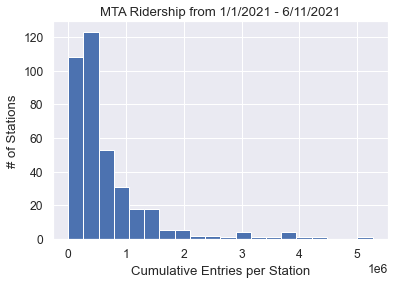

In [30]:
# Create histogram
plt.hist(station_totals['cumulative_entries'], bins=20);
plt.xlabel('Cumulative Entries per Station')
plt.ylabel('# of Stations')
plt.title('MTA Ridership from 1/1/2021 - 6/11/2021');

We can visualize the distribution of daily entries at different subway stations. The right skew indicates that the majority of subway stations carry a lower volume of passengers, while just a few stations carry a high volume. The **maximum** cumulative entries is nearly five million at 34th St-Penn Station between January and June of 2021.

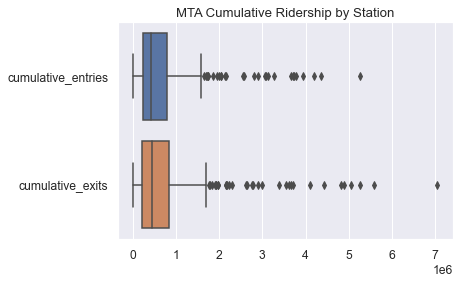

In [31]:
# Create boxplot 
sns.boxplot(data=station_totals, orient='h').set(title='MTA Cumulative Ridership by Station');

The same pattern holds true for exits. The handful of high-volume subway stations are true outliers.

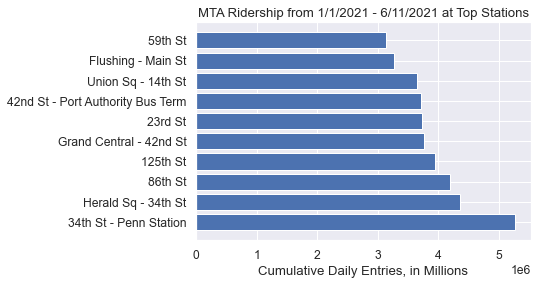

In [32]:
# Create horizontal bar plot of top 10 stations
plt.barh(y=top_100_stations['station'][:10], width=top_100_stations['cumulative_entries'][:10], height=.8)
plt.xlabel("Cumulative Daily Entries, in Millions");
plt.title('MTA Ridership from 1/1/2021 - 6/11/2021 at Top Stations');

### Importing Geo-spatial Data

In [33]:
# Import outline of New York borough boundaries
nyc_map = gpd.read_file('/Users/elizabethnaameh/Downloads/Borough Boundaries/geo_export_e316ba40-84b8-4383-86a0-29836a646fad.shp')
nyc_map = nyc_map[nyc_map['boro_name'] != 'Staten Island'] # no data in Staten Island
nyc_map

boro_code  boro_name    shape_area     shape_leng  \
1        2.0      Bronx  1.187231e+09  464720.015850   
2        3.0   Brooklyn  1.934095e+09  729595.348997   
3        4.0     Queens  3.042318e+09  903938.441308   
4        1.0  Manhattan  6.366055e+08  359935.015632   

                                            geometry  
1  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...  
2  MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...  
3  MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...  
4  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...

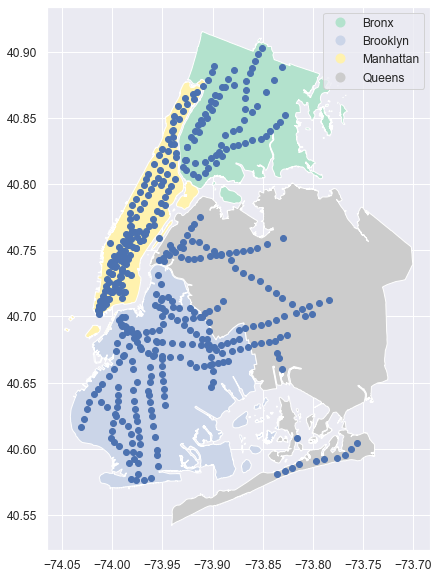

In [34]:
# Import locations of subway stations
station_positions = gpd.read_file('/Users/elizabethnaameh/Downloads/Subway Stations/geo_export_6dddf387-5733-4ddc-87de-6189b7261929.shp')
station_positions = station_positions.rename(columns = {'name':'station'})

# Plot stations over map
fig, ax = plt.subplots(figsize = (10, 10))
nyc_map.plot(ax = ax, cmap = 'Pastel2', column = 'boro_name', legend = True)
station_positions.plot(ax=ax);

In [35]:
# merge all dataframes
station_positions_with_boro = gpd.sjoin(station_positions, nyc_map, how="left", op='intersects')
station_positions_with_boro.drop(labels = ['notes', 'line', 'objectid', 'url', 'index_right', 'shape_area', 'shape_leng', 'boro_code'], axis =1, inplace=True)

top_100_stations = top_100_stations.merge(station_positions_with_boro, on='station', how = 'left')
top_100_stations.head()

station  cumulative_entries  cumulative_exits  \
0  34th St - Penn Station             5262867           7053345   
1  34th St - Penn Station             5262867           7053345   
2     Herald Sq - 34th St             4363996           5591609   
3     Herald Sq - 34th St             4363996           5591609   
4                 86th St             4192026           5255493   

                     geometry  boro_name  
0  POINT (-73.99106 40.75037)  Manhattan  
1  POINT (-73.99339 40.75229)  Manhattan  
2  POINT (-73.98794 40.74964)  Manhattan  
3  POINT (-73.98777 40.74979)  Manhattan  
4  POINT (-73.97622 40.78864)  Manhattan

We notice that there are multiple rows for the same station. Let's look deeper.

In [36]:
top_100_stations[top_100_stations.duplicated(subset = ['station', 'geometry'], keep='first')] # Lists duplicates

station  cumulative_entries  cumulative_exits  \
94   72nd St             1466749           1663619   
95   72nd St             1466749           1663619   
96   72nd St             1466749           1663619   
110     none             1311776           1582364   
140     none             1021310           1682483   
168     none              887337            887663   
177     none              822205            959831   
180     none              804764            106367   
184  33rd St              795885            648651   
185  33rd St              795885            648651   
197     none              730743            809377   

                       geometry  boro_name  
94   POINT (-73.97634 40.77552)  Manhattan  
95   POINT (-73.98197 40.77845)  Manhattan  
96   POINT (-73.95836 40.76880)  Manhattan  
110                        None        NaN  
140                        None        NaN  
168                        None        NaN  
177                        None        NaN  
180                        None        NaN  
184  POINT (-73.98208 40.74608)  Manhattan  
185  POINT (-73.93100 40.74459)     Queens  
197                        None        NaN

From above, we see there are both duplicate entries and also empty rows in our new stations dataframe. We can clean both.

In [37]:
top_100_stations.dropna(inplace=True) # Drop nulls
top_100_stations.drop_duplicates(subset=['station'], inplace=True) # Drop duplicates, keeping the first
top_100_stations.shape

(101, 5)

## Data Visualization

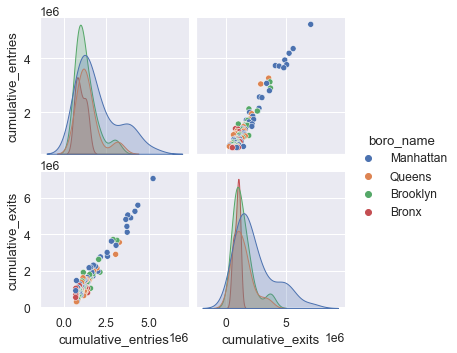

In [38]:
sns.pairplot(data=top_100_stations, hue='boro_name');

The above pairplot cearly shows that Manhattan is the most popular borough, by `daily_entries` and `daily_exits`. Let's look at the stations overlaid on a map of NYC for a spatial approach.

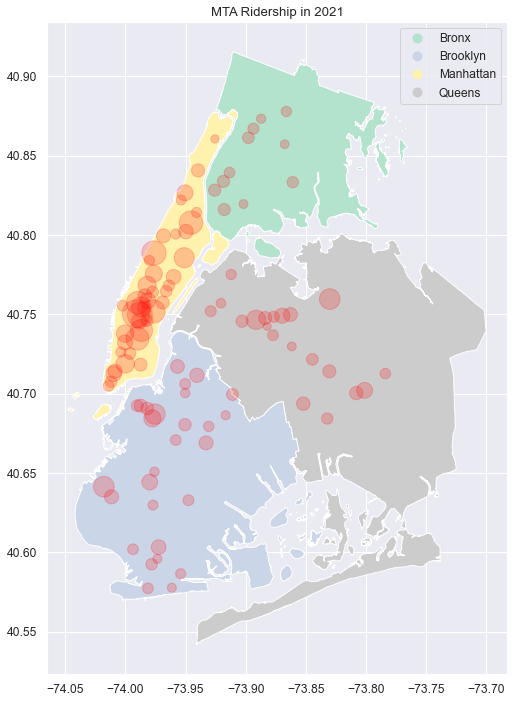

In [39]:
station_gs = GeoSeries(top_100_stations['geometry'])
marker_size = (top_100_stations['cumulative_entries'] + top_100_stations['cumulative_exits'])/4000 # divided by 10 for reasonable marker size

# plot NYC map and total foot traffic by station 
fig, ax = plt.subplots(figsize = (12, 12))
nyc_map.plot(ax = ax, cmap = 'Pastel2', column = 'boro_name', legend = True)
station_gs.plot(ax = ax, marker='.', color = 'red', 
                markersize = marker_size, alpha = 1/5)

#ax.set_axis_off()
ax.set_title("MTA Ridership in 2021")
plt.show()

Each dot represents one of the top 100 stations and the size of the dots indicates the amount of foot traffic. The map shows that Manhattan is by far the busiest borough in terms of subway use. 

## Visualizing Daily Foot Traffic

In [40]:
# Calculate total daily foot traffic per day per station
stations_daily['daily_traffic'] = stations_daily['daily_entries'] + stations_daily['daily_exits']
stations_daily_full = stations_daily.copy(deep=True)
stations_daily['station'] = stations_daily['station'].map(stations_dict)

stations_daily

station       date  daily_entries  daily_exits  daily_traffic
0        none 2021-01-02           3673         6054           9727
1        none 2021-01-03           2547         4537           7084
2        none 2021-01-04           5303         8145          13448
3        none 2021-01-05           5468         8332          13800
4        none 2021-01-06           5603         8532          14135
...       ...        ...            ...          ...            ...
63512     NaN 2021-06-14           1169         1322           2491
63513     NaN 2021-06-15           1228         1420           2648
63514     NaN 2021-06-16           1158         1429           2587
63515     NaN 2021-06-17           1202         1429           2631
63516     NaN 2021-06-18           1186         1376           2562

[63517 rows x 5 columns]

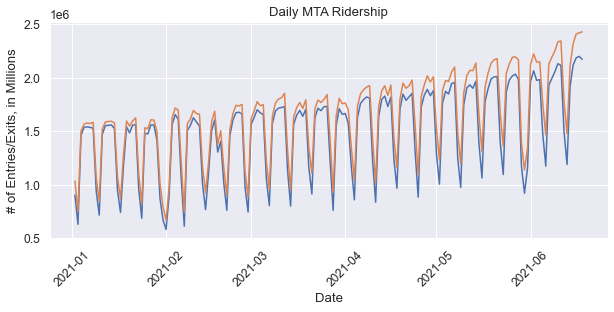

In [41]:
# Calculate total daily foot traffic across all MTA stations
mta_daily_total = stations_daily.groupby('date').sum().reset_index()

plt.figure(figsize=(10, 4))
plt.plot(mta_daily_total['date'], mta_daily_total['daily_entries'])
plt.plot(mta_daily_total['date'], mta_daily_total['daily_exits'])
plt.ylabel('# of Entries/Exits, in Millions')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily MTA Ridership');

By graphing daily entries and exits, we see a general increase in subway ridership over time, with regular sharp dips representing the weekends. We want to fit a trendline to observe general growth over time, and this requires us to reduce noise and regularize our data. 

We start by creating a `weekday_mask` to restrict analysis to weekdays only.

Still, there are some outliers, as several dates represent federal holidays. Notably:
* January 18 = MLK Day
* February 15 = Washington's birthday
* May 31 = Memorial Day

We create a `rm_holidays_mask`, as well, so that outliers don't affect the outcome of our linear regression model.

In [42]:
# Assign each date a "week_day" ranging from 0-6
mta_daily_total['week_day'] = mta_daily_total['date'].dt.dayofweek

# Create weekday and remove holiday masks to filter outliers
weekday_mask = (mta_daily_total['week_day'] < 5)
rm_holidays_mask = ((mta_daily_total['date'] != '2021-01-18') & (mta_daily_total['date'] != '2021-02-15') & (mta_daily_total['date'] != '2021-05-31'))

# fig = px.scatter(mta_daily_total, x="date", y="daily_traffic", trendline="ols") # plot all days 
# fig = px.scatter(mta_daily_total[weekday_mask], x="date", y="daily_traffic", trendline="ols") # remove weekends

# Plot daily total traffic as time series, weekdays only and no holidays
fig = px.scatter(mta_daily_total[weekday_mask & rm_holidays_mask], x="date", y="daily_traffic", trendline="ols")
fig.show()

In [43]:
# Calculate *average* total daily foot traffic for all MTA stations
mta_daily_avg = stations_daily.groupby('date').mean().reset_index()

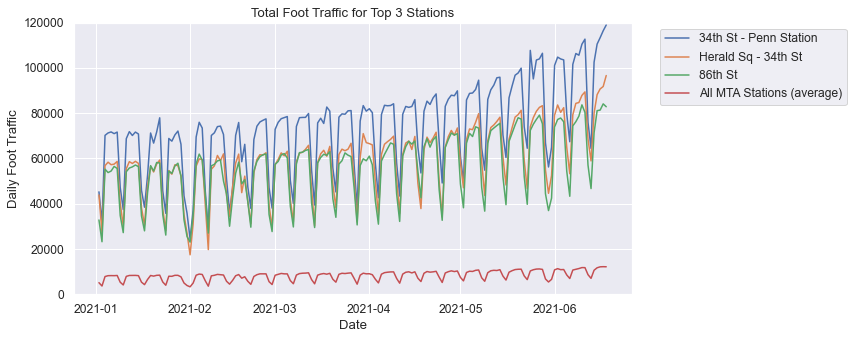

In [44]:
# Create graphing function which isolates daily foot traffic per station
def vis_top_stations(x):
    top_stations_list = list(top_100_stations.head(x)['station'].unique())
    
    plt.figure(figsize=(10, 5))
    for station in top_stations_list:
        station_daily_x = stations_daily[stations_daily['station'] == station].copy()
        plt.plot(station_daily_x['date'], station_daily_x['daily_traffic'])
        
    plt.plot(mta_daily_avg['date'], mta_daily_avg['daily_traffic'])
    plt.xlabel('Date')
    plt.ylabel('Daily Foot Traffic')
    plt.ylim(0, 120000)
    plt.title(f'Total Foot Traffic for Top {x} Stations')
    
    top_stations_list.append('All MTA Stations (average)')
    plt.legend(top_stations_list, bbox_to_anchor=(1.04,1), loc="upper left")
    
vis_top_stations(3)

In [45]:
stations_daily_with_boro = stations_daily.merge(top_100_stations, on='station', how = 'inner')
stations_daily_with_boro.drop(['daily_entries', 'daily_exits', 'cumulative_entries', 'cumulative_exits'], axis=1, inplace=True)
stations_daily_with_boro.head(10)

station       date  daily_traffic                    geometry  boro_name
0  103rd St 2021-01-02          11160  POINT (-73.96838 40.79945)  Manhattan
1  103rd St 2021-01-03           8665  POINT (-73.96838 40.79945)  Manhattan
2  103rd St 2021-01-04          17130  POINT (-73.96838 40.79945)  Manhattan
3  103rd St 2021-01-05          18668  POINT (-73.96838 40.79945)  Manhattan
4  103rd St 2021-01-06          18867  POINT (-73.96838 40.79945)  Manhattan
5  103rd St 2021-01-07          18966  POINT (-73.96838 40.79945)  Manhattan
6  103rd St 2021-01-08          18764  POINT (-73.96838 40.79945)  Manhattan
7  103rd St 2021-01-09          12198  POINT (-73.96838 40.79945)  Manhattan
8  103rd St 2021-01-10           9635  POINT (-73.96838 40.79945)  Manhattan
9  103rd St 2021-01-11          18559  POINT (-73.96838 40.79945)  Manhattan

In [46]:
# Get list of top x stations by borough 
def get_top_stations_by_boro(x):
    boro_list = list(top_100_stations['boro_name'].unique())
    top_stations_by_boro = pd.DataFrame()
    for boro in boro_list:
        boro_mask = top_100_stations['boro_name'] == boro
        boro_df = top_100_stations[boro_mask]
        top_stations_by_boro = pd.concat([top_stations_by_boro, boro_df.head(x)])
    return top_stations_by_boro

# Filter daily station count info to just the top x stations by boro
top_stations_by_boro = list(get_top_stations_by_boro(3)['station'].unique())
mask = np.isin(stations_daily_with_boro['station'], top_stations_by_boro)
stations_daily_reduced = stations_daily_with_boro[mask]
stations_daily_reduced

station       date  daily_traffic  \
1680    161st St - Yankee Stadium 2021-01-02           9627   
1681    161st St - Yankee Stadium 2021-01-03           7627   
1682    161st St - Yankee Stadium 2021-01-04          12884   
1683    161st St - Yankee Stadium 2021-01-05          13603   
1684    161st St - Yankee Stadium 2021-01-06          13612   
...                           ...        ...            ...   
13771  Jackson Hts - Roosevelt Av 2021-06-14          43172   
13772  Jackson Hts - Roosevelt Av 2021-06-15          45240   
13773  Jackson Hts - Roosevelt Av 2021-06-16          46866   
13774  Jackson Hts - Roosevelt Av 2021-06-17          46996   
13775  Jackson Hts - Roosevelt Av 2021-06-18          47068   

                         geometry boro_name  
1680   POINT (-73.92569 40.82823)     Bronx  
1681   POINT (-73.92569 40.82823)     Bronx  
1682   POINT (-73.92569 40.82823)     Bronx  
1683   POINT (-73.92569 40.82823)     Bronx  
1684   POINT (-73.92569 40.82823)     Bronx  
...                           ...       ...  
13771  POINT (-73.89130 40.74654)    Queens  
13772  POINT (-73.89130 40.74654)    Queens  
13773  POINT (-73.89130 40.74654)    Queens  
13774  POINT (-73.89130 40.74654)    Queens  
13775  POINT (-73.89130 40.74654)    Queens  

[2016 rows x 5 columns]

In [73]:
%%capture --no-display 
# suppress warning

stations_daily_reduced['week_day'] = stations_daily_reduced['date'].dt.dayofweek
weekday_mask = (stations_daily_reduced['week_day'] < 5)
rm_holidays_mask = ((stations_daily_reduced['date'] != '2021-01-18') & (stations_daily_reduced['date'] != '2021-02-15') & (stations_daily_reduced['date'] != '2021-05-31'))

stations_reduced_weekdays = stations_daily_reduced[weekday_mask & rm_holidays_mask]

fig1 = px.scatter(stations_reduced_weekdays, x="date", y="daily_traffic", color='boro_name', trendline="ols")
fig1.show()

results = px.get_trendline_results(fig1)
#results.query("boro_name == 'Bronx'").px_fit_results.iloc[0].summary()

In [48]:
top_100_stations

station  cumulative_entries  cumulative_exits  \
0     34th St - Penn Station             5262867           7053345   
2        Herald Sq - 34th St             4363996           5591609   
4                    86th St             4192026           5255493   
9                   125th St             3941338           4897036   
13   Grand Central - 42nd St             3769438           5054932   
..                       ...                 ...               ...   
200             Prospect Ave              704483            566195   
202        Bedford Park Blvd              700029            677263   
203              Gun Hill Rd              698492           1034768   
205  137th St - City College              695301            903948   
206              Pelham Pkwy              693712            532767   

                       geometry  boro_name  
0    POINT (-73.99106 40.75037)  Manhattan  
2    POINT (-73.98794 40.74964)  Manhattan  
4    POINT (-73.97622 40.78864)  Manhattan  
9    POINT (-73.94550 40.80775)  Manhattan  
13   POINT (-73.97671 40.75181)  Manhattan  
..                          ...        ...  
200  POINT (-73.90178 40.81949)      Bronx  
202  POINT (-73.88714 40.87324)      Bronx  
203  POINT (-73.86613 40.87784)      Bronx  
205  POINT (-73.95368 40.82201)  Manhattan  
206  POINT (-73.86748 40.85719)      Bronx  

[101 rows x 5 columns]

In [49]:
stations_daily_full['week_day'] = stations_daily_full['date'].dt.dayofweek
stations_daily_full['station'] = stations_daily_full['station'].map(stations_dict)

# Clean station column in 2021 dataset
stations_daily.dropna(subset=['station'], inplace=True) # drop null station names
stations_daily = stations_daily[stations_daily['station']!='none'] #drop 'none' station names

stations_daily_full

station       date  daily_entries  daily_exits  daily_traffic  week_day
0        none 2021-01-02           3673         6054           9727         5
1        none 2021-01-03           2547         4537           7084         6
2        none 2021-01-04           5303         8145          13448         0
3        none 2021-01-05           5468         8332          13800         1
4        none 2021-01-06           5603         8532          14135         2
...       ...        ...            ...          ...            ...       ...
63512     NaN 2021-06-14           1169         1322           2491         0
63513     NaN 2021-06-15           1228         1420           2648         1
63514     NaN 2021-06-16           1158         1429           2587         2
63515     NaN 2021-06-17           1202         1429           2631         3
63516     NaN 2021-06-18           1186         1376           2562         4

[63517 rows x 6 columns]

In [50]:
from sklearn.linear_model import LinearRegression

weekday_mask = (stations_daily_full['week_day'] < 5)
rm_holidays_mask = ((stations_daily_full['date'] != '2021-01-18') & (stations_daily_full['date'] != '2021-02-15') & (stations_daily_full['date'] != '2021-05-31'))
stations_daily_full_reg = stations_daily_full[weekday_mask & rm_holidays_mask]

def get_slopes(station_name):
    regressor = LinearRegression()
    mask = stations_daily_full_reg['station'] == station_name
    Y = stations_daily_full_reg[mask]['daily_traffic']
    X = np.array(list(range(len(stations_daily_full_reg[mask])))) # does X need to be an integer, or can it be a date? can we do regression with datetime?
    X = X.reshape(-1, 1)
    regressor.fit(X, Y)
    return regressor.coef_

In [51]:
full_stations_list = list(top_100_stations['station'].unique())

stations_growth_dict = {}
for station in full_stations_list:
    stations_growth_dict[station] = round(float(get_slopes(station)),3)

In [52]:
stations_growth_df = pd.DataFrame.from_dict(stations_growth_dict, orient='index', columns=['coeff'])
stations_growth_df.sort_values(by='coeff', ascending=False, inplace=True)
stations_growth_df.head(25)

coeff
34th St - Penn Station             374.089
Herald Sq - 34th St                292.085
Grand Central - 42nd St            291.135
Union Sq - 14th St                 265.915
86th St                            245.894
23rd St                            238.103
Times Sq - 42nd St                 219.830
42nd St - Port Authority Bus Term  210.837
Fulton St                          207.091
Canal St                           187.411
125th St                           179.074
14th St                            169.729
59th St - Columbus Circle          155.886
W 4th St - Washington Sq (Lower)   155.369
96th St                            154.007
Flushing - Main St                 141.636
59th St                            138.351
World Trade Center                 132.784
28th St                            125.621
Chambers St                        123.683
Atlantic Av - Barclay's Center     115.704
Bedford Ave                        114.474
8th Ave                            113.794
Jackson Hts - Roosevelt Av         112.036
50th St                            101.694

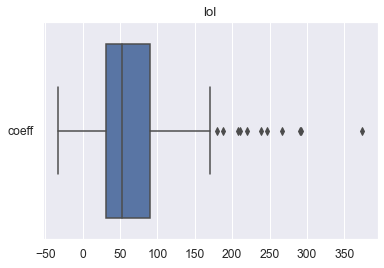

In [53]:
# Create boxplot 
sns.boxplot(data=stations_growth_df, orient='h').set(title='lol');

/Users/elizabethnaameh/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning:

invalid value encountered in sqrt



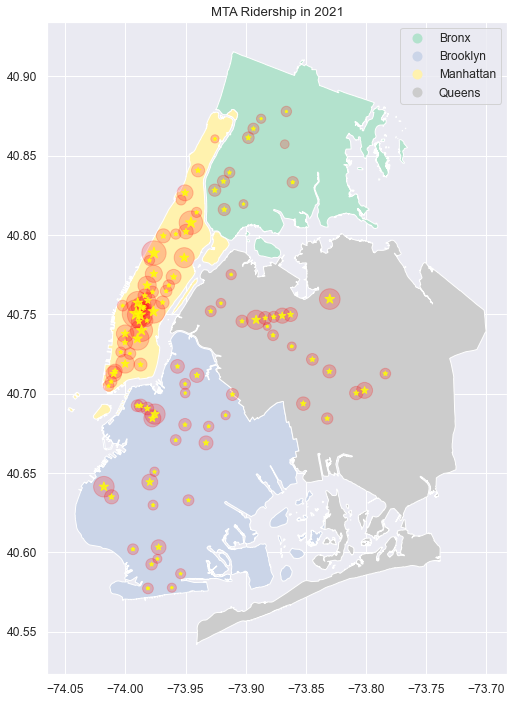

In [54]:
marker_size = (top_100_stations['cumulative_entries'] + top_100_stations['cumulative_exits'])/4000 # divided by 10 for reasonable marker size
star_size = stations_growth_df['coeff']

# plot NYC map and total foot traffic by station 
fig, ax = plt.subplots(figsize = (12, 12))
nyc_map.plot(ax = ax, cmap = 'Pastel2', column = 'boro_name', legend = True)
station_gs.plot(ax = ax, marker='.', color = 'red', 
                markersize = marker_size, alpha = 1/5)
station_gs.plot(ax = ax, marker='*', color = 'yellow', 
                markersize = star_size/2, alpha = .8)

#ax.set_axis_off()
ax.set_title("MTA Ridership in 2021")
plt.show()

## Pulling Old Data for Comparison

In [55]:
# Read in pre-pandemic MTA data from March-June of 2019
mta_19 = pd.read_sql('SELECT * FROM mta_data WHERE date LIKE \'03%19\' OR date LIKE \'04%19\' OR date LIKE \'05%19\' OR date LIKE \'06%19\';', engine)

In [56]:
# Pre-process data
mta_19.columns= mta_19.columns.str.lower()
mta_19['date_time'] = pd.to_datetime(mta_19['date'] + ' ' + mta_19['time']) # create date-time objects
mta_19.sort_values(["c/a", "unit", "scp", "station", "date_time"], 
                          inplace=True, ascending=True) # sort data
mta_19.drop_duplicates(subset=["c/a", "unit", "scp", "station", "date_time"], inplace=True) #drop duplicates
mta_19.drop(["desc"], axis=1, errors="ignore", inplace=True) #reduce columns
mta_19

c/a  unit       scp        station linename division        date  \
3477344   A002  R051  02-00-00          59 ST  NQR456W      BMT  03/01/2019   
3477345   A002  R051  02-00-00          59 ST  NQR456W      BMT  03/01/2019   
3477346   A002  R051  02-00-00          59 ST  NQR456W      BMT  03/01/2019   
3477347   A002  R051  02-00-00          59 ST  NQR456W      BMT  03/01/2019   
3477348   A002  R051  02-00-00          59 ST  NQR456W      BMT  03/01/2019   
...        ...   ...       ...            ...      ...      ...         ...   
205958   TRAM2  R469  00-05-01  RIT-ROOSEVELT        R      RIT  06/28/2019   
205959   TRAM2  R469  00-05-01  RIT-ROOSEVELT        R      RIT  06/28/2019   
205960   TRAM2  R469  00-05-01  RIT-ROOSEVELT        R      RIT  06/28/2019   
205961   TRAM2  R469  00-05-01  RIT-ROOSEVELT        R      RIT  06/28/2019   
205962   TRAM2  R469  00-05-01  RIT-ROOSEVELT        R      RIT  06/28/2019   

             time  entries    exits           date_time  
3477344  03:00:00  6962094  2361672 2019-03-01 03:00:00  
3477345  07:00:00  6962111  2361714 2019-03-01 07:00:00  
3477346  11:00:00  6962243  2362017 2019-03-01 11:00:00  
3477347  15:00:00  6962502  2362082 2019-03-01 15:00:00  
3477348  19:00:00  6963303  2362149 2019-03-01 19:00:00  
...           ...      ...      ...                 ...  
205958   05:00:00     5554      379 2019-06-28 05:00:00  
205959   09:00:00     5554      379 2019-06-28 09:00:00  
205960   13:00:00     5554      379 2019-06-28 13:00:00  
205961   17:00:00     5554      379 2019-06-28 17:00:00  
205962   21:00:00     5554      379 2019-06-28 21:00:00  

[3505952 rows x 11 columns]

In [57]:
turnstiles_19 = (mta_19.groupby(["c/a", "unit", "scp", "station", "date"],as_index=False)
                        [['entries', 'exits']].max())
turnstiles_19["previous_entries"] = turnstiles_19.groupby(['c/a', 'unit', 'station', 'scp'])['entries'].shift(1)
turnstiles_19["previous_exits"] = turnstiles_19.groupby(['c/a', 'unit', 'station', 'scp'])['exits'].shift(1)
turnstiles_19.dropna(subset=['previous_entries', 'previous_exits'], axis=0, inplace=True)
turnstiles_19 = turnstiles_19.astype({'previous_entries': 'int32', 'entries': 'int32', 'exits':'int32', 'previous_exits': 'int32', })
turnstiles_19

c/a  unit       scp        station        date  entries    exits  \
1        A002  R051  02-00-00          59 ST  03/02/2019  6964320  2362403   
2        A002  R051  02-00-00          59 ST  03/03/2019  6964888  2362582   
3        A002  R051  02-00-00          59 ST  03/04/2019  6966123  2362977   
4        A002  R051  02-00-00          59 ST  03/05/2019  6967602  2363452   
5        A002  R051  02-00-00          59 ST  03/06/2019  6969056  2363976   
...       ...   ...       ...            ...         ...      ...      ...   
580722  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/24/2019     5554      379   
580723  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/25/2019     5554      379   
580724  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/26/2019     5554      379   
580725  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/27/2019     5554      379   
580726  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/28/2019     5554      379   

        previous_entries  previous_exits  
1                6963578         2362196  
2                6964320         2362403  
3                6964888         2362582  
4                6966123         2362977  
5                6967602         2363452  
...                  ...             ...  
580722              5554             379  
580723              5554             379  
580724              5554             379  
580725              5554             379  
580726              5554             379  

[575795 rows x 9 columns]

In [58]:
%%capture
turnstiles_19["daily_entries"] = turnstiles_19.apply(get_daily_entry_counts, axis=1, max_counter=10000)
turnstiles_19["daily_exits"] = turnstiles_19.apply(get_daily_exit_counts, axis=1, max_counter=10000)

In [59]:
stations_19 = turnstiles_19.groupby(["station", "date"])[['daily_entries', 'daily_exits']].sum().reset_index()
stations_19['date'] = pd.to_datetime(stations_19['date'])
stations_19['daily_traffic'] = stations_19['daily_entries'] + stations_19['daily_exits']
stations_19.rename(columns={'date': 'date_19'}, inplace=True)
stations_19

station    date_19  daily_entries  daily_exits  daily_traffic
0           1 AV 2019-03-02            231          232            463
1           1 AV 2019-03-03              6           51             57
2           1 AV 2019-03-04          15043        16390          31433
3           1 AV 2019-03-05          20090        22223          42313
4           1 AV 2019-03-06          21066        22843          43909
...          ...        ...            ...          ...            ...
44877  ZEREGA AV 2019-06-24           2704         2532           5236
44878  ZEREGA AV 2019-06-25           2659         2469           5128
44879  ZEREGA AV 2019-06-26           2860         2730           5590
44880  ZEREGA AV 2019-06-27           2634         2569           5203
44881  ZEREGA AV 2019-06-28           2508         2406           4914

[44882 rows x 5 columns]

In [72]:
%%capture --no-display

# Rename stations in 2019 stations datasest
stations_19['station'] = stations_19['station'].map(stations_dict)

# Clean station column in 2021 dataset
stations_daily.dropna(subset=['station'], inplace=True) # drop null station names
stations_daily = stations_daily[stations_daily['station']!='none'] #drop 'none' station names

# Create new column in 2021 stations dataframe for the corresponding pre-pandemic date
stations_daily['date_19'] = stations_daily['date'] - timedelta(weeks=104)
stations_daily

station       date  daily_entries  daily_exits  daily_traffic  \
168          103rd St 2021-01-02           5239         5921          11160   
169          103rd St 2021-01-03           3906         4759           8665   
170          103rd St 2021-01-04           8327         8803          17130   
171          103rd St 2021-01-05           8997         9671          18668   
172          103rd St 2021-01-06           9245         9622          18867   
...               ...        ...            ...          ...            ...   
62672  Woodhaven Blvd 2021-06-14          10866        10728          21594   
62673  Woodhaven Blvd 2021-06-15          11537        11768          23305   
62674  Woodhaven Blvd 2021-06-16          12112        11968          24080   
62675  Woodhaven Blvd 2021-06-17          12092        11906          23998   
62676  Woodhaven Blvd 2021-06-18          12256        12290          24546   

         date_19  
168   2019-01-05  
169   2019-01-06  
170   2019-01-07  
171   2019-01-08  
172   2019-01-09  
...          ...  
62672 2019-06-17  
62673 2019-06-18  
62674 2019-06-19  
62675 2019-06-20  
62676 2019-06-21  

[17304 rows x 6 columns]

In [61]:
# Merge daily station data for 2021 and 2019 for dates common to both
stations_19_21 = pd.merge(stations_daily, stations_19,  how='inner', left_on=['station', 'date_19'], right_on = ['station', 'date_19'], suffixes = (None, '_19'))
stations_19_21

station       date  daily_entries  daily_exits  daily_traffic  \
0            103rd St 2021-02-27           5898         6548          12446   
1            103rd St 2021-02-28           4636         5449          10085   
2            103rd St 2021-03-01           9426         9896          19322   
3            103rd St 2021-03-02          10332        10803          21135   
4            103rd St 2021-03-03          10478        10864          21342   
...               ...        ...            ...          ...            ...   
11975  Woodhaven Blvd 2021-06-14          10866        10728          21594   
11976  Woodhaven Blvd 2021-06-15          11537        11768          23305   
11977  Woodhaven Blvd 2021-06-16          12112        11968          24080   
11978  Woodhaven Blvd 2021-06-17          12092        11906          23998   
11979  Woodhaven Blvd 2021-06-18          12256        12290          24546   

         date_19  daily_entries_19  daily_exits_19  daily_traffic_19  
0     2019-03-02             18699           14043             32742  
1     2019-03-03             15062           12213             27275  
2     2019-03-04             23895           16153             40048  
3     2019-03-05             31965           22202             54167  
4     2019-03-06             32332           22354             54686  
...          ...               ...             ...               ...  
11975 2019-06-17             25100           13801             38901  
11976 2019-06-18             24967           13757             38724  
11977 2019-06-19             25614           14175             39789  
11978 2019-06-20             25436           13868             39304  
11979 2019-06-21             25476           14517             39993  

[11980 rows x 9 columns]

In [62]:
# Create new column to keep track of 'week number' 
stations_19_21.insert(2, 'week_num', stations_19_21['date'].dt.isocalendar().week)

# Drop the first week, since it only has 2 days of data
first_week = stations_19_21['week_num'].min()
stations_19_21 = stations_19_21[stations_19_21['week_num'] != first_week]

# Calculate weekly traffic per station for both years
stations_19_21_weekly = stations_19_21.groupby(['station', 'week_num'])[['daily_traffic', 'daily_traffic_19']].sum().reset_index()
stations_19_21_weekly.rename(columns={'daily_traffic':'weekly_traffic', 'daily_traffic_19': 'weekly_traffic_19'}, inplace=True)
stations_19_21_weekly

station  week_num  weekly_traffic  weekly_traffic_19
0               103rd St         9          127328             309427
1               103rd St        10          130942             327508
2               103rd St        11          130033             319849
3               103rd St        12          131774             325728
4               103rd St        13          127105             332658
...                  ...       ...             ...                ...
1611  World Trade Center        20          206571             630333
1612  World Trade Center        21          193760             537398
1613  World Trade Center        22          197869             606325
1614  World Trade Center        23          224877             608751
1615  World Trade Center        24          190145             610379

[1616 rows x 4 columns]

In [63]:
stations_19_21_weekly['pct_diff'] = (stations_19_21_weekly['weekly_traffic']-stations_19_21_weekly['weekly_traffic_19'])/(stations_19_21_weekly['weekly_traffic_19'])
stations_19_21_weekly.head()

station  week_num  weekly_traffic  weekly_traffic_19  pct_diff
0  103rd St         9          127328             309427 -0.588504
1  103rd St        10          130942             327508 -0.600187
2  103rd St        11          130033             319849 -0.593455
3  103rd St        12          131774             325728 -0.595448
4  103rd St        13          127105             332658 -0.617911

We now have the percent change in subway ridership from pre-pandemic to the post-pandemic times. We can see the percentage drop in ridership per station per week. We would like to sort these so we can look more closely into any small percentages; smaller percent differences indicate a fuller return to pre-pandemic ridership levels. If we observe a pattern, this could offer a window into which stations are returning to normal the fastest. 

In [64]:
stations_19_21_weekly.sort_values(by='pct_diff', ascending=False).head(10)

station  week_num  weekly_traffic  weekly_traffic_19  \
118                  145th St        15          183328             250761   
187                  168th St        20          139024             193641   
1251            Junction Blvd        12          178094             248407   
28    103rd St - Corona Plaza        21          142865             199976   
185                  168th St        18          123843             173825   
44                   111th St        21           93876             132865   
1263            Junction Blvd        24          134421             192977   
215                  18th Ave        16           68978              99450   
1047         Ft Hamilton Pkwy        16           63137              91144   
26    103rd St - Corona Plaza        19          145031             211660   

      pct_diff  
118  -0.268913  
187  -0.282053  
1251 -0.283056  
28   -0.285589  
185  -0.287542  
44   -0.293448  
1263 -0.303435  
215  -0.306405  
1047 -0.307283  
26   -0.314793

In [65]:
stations_19_21_weekly.sort_values(by='pct_diff', ascending=False).head(50)['station'].value_counts()

Junction Blvd              10
103rd St - Corona Plaza     9
111th St                    8
168th St                    5
Ft Hamilton Pkwy            4
Flushing Ave                4
82nd St - Jackson Hts       3
90th St - Elmhurst Av       2
137th St - City College     1
167th St                    1
18th Ave                    1
Bedford Ave                 1
145th St                    1
Name: station, dtype: int64

We notice Junction Blvd, 103rd St-Corona Plaza, 111th St, and 168th St most consistently have the smallest gaps between pre- and post-pandemic ridership levels. The first three are consecutive stations in Queens, and 168th St is in Manhattan. We can look into these stations' ridership patterns for future/further analyses.

In [66]:
mta_19_21_weekly = stations_19_21_weekly.groupby('week_num')[['weekly_traffic', 'weekly_traffic_19', 'pct_diff']].mean().reset_index()
mta_19_21_weekly

week_num  weekly_traffic  weekly_traffic_19  pct_diff
0          9   135265.376238      406069.980198 -0.603639
1         10   139310.316832      430731.633663 -0.617633
2         11   139118.198020      419602.217822 -0.613222
3         12   141191.297030      424898.950495 -0.612564
4         13   138657.386139      434876.118812 -0.630765
5         14   146445.158416      433174.217822 -0.606079
6         15   148569.237624      418800.326733 -0.583483
7         16   151578.831683      409002.376238 -0.558286
8         17   155259.990099      430486.415842 -0.583080
9         18   157500.514851      428160.574257 -0.579919
10        19   162651.376238      438800.891089 -0.577293
11        20   166798.524752      427803.099010 -0.560304
12        21   164364.544554      393140.722772 -0.528450
13        22   163200.584158      431926.227723 -0.573220
14        23   178919.653465      428543.118812 -0.533647
15        24   145333.643564      350410.297030 -0.531405

In [67]:
#rewrite this function with start and stop??? instead of just the first x, maybe i want to get stations between y and z???
#maybe even groupby borough? zip code? LOL jk.

def vis_return_to_normal(top_stations_list):
    #top_stations_list = list(top_100_stations.head(x)['station'].unique())
    
    plt.figure(figsize=(10, 5))
    for station in top_stations_list:
        mask = stations_19_21_weekly['station'] == station
        station_x = stations_19_21_weekly[mask].copy()
        plt.plot(station_x['week_num'], station_x['pct_diff'])
        #plt.plot(station_x['week_num'], station_x['pct_diff'])
        
    plt.plot(mta_19_21_weekly['week_num'], mta_19_21_weekly['pct_diff'])
    top_stations_list.append('All MTA Stations (average)')
    plt.legend(top_stations_list, bbox_to_anchor=(1.04,1), loc="upper left")

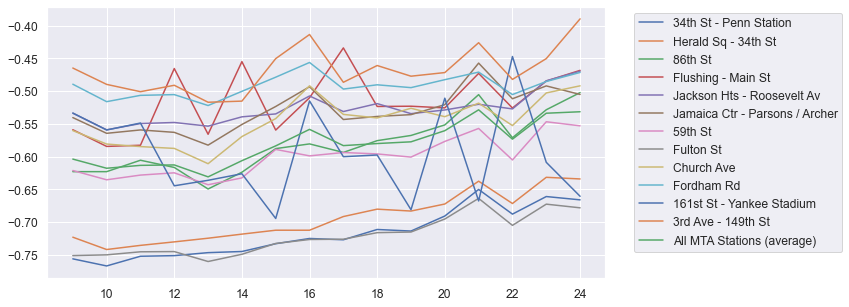

In [68]:
vis_return_to_normal(top_stations_by_boro)

In [69]:
stations_19_21_weekly = stations_19_21_weekly.merge(station_positions_with_boro, on='station', how = 'left')
stations_19_21_weekly

station  week_num  weekly_traffic  weekly_traffic_19  \
0               103rd St         9          127328             309427   
1               103rd St         9          127328             309427   
2               103rd St         9          127328             309427   
3               103rd St        10          130942             327508   
4               103rd St        10          130942             327508   
...                  ...       ...             ...                ...   
3131  World Trade Center        20          206571             630333   
3132  World Trade Center        21          193760             537398   
3133  World Trade Center        22          197869             606325   
3134  World Trade Center        23          224877             608751   
3135  World Trade Center        24          190145             610379   

      pct_diff                    geometry  boro_name  
0    -0.588504  POINT (-73.96838 40.79945)  Manhattan  
1    -0.588504  POINT (-73.96137 40.79606)  Manhattan  
2    -0.588504  POINT (-73.94748 40.79060)  Manhattan  
3    -0.600187  POINT (-73.96838 40.79945)  Manhattan  
4    -0.600187  POINT (-73.96137 40.79606)  Manhattan  
...        ...                         ...        ...  
3131 -0.672283  POINT (-74.00974 40.71256)  Manhattan  
3132 -0.639448  POINT (-74.00974 40.71256)  Manhattan  
3133 -0.673659  POINT (-74.00974 40.71256)  Manhattan  
3134 -0.630593  POINT (-74.00974 40.71256)  Manhattan  
3135 -0.688480  POINT (-74.00974 40.71256)  Manhattan  

[3136 rows x 7 columns]

In [70]:
stations_19_21_weekly.rename(columns = {'boro_name_x': 'boro_name'}, inplace=True)

In [71]:
# Filter daily station count info to just the top x stations by boro
top_stations_by_boro = list(get_top_stations_by_boro(3)['station'].unique())
mask = np.isin(stations_19_21_weekly['station'], top_stations_by_boro)
stations_19_21_weekly_red = stations_19_21_weekly[mask]
stations_19_21_weekly_red

fig2 = px.scatter(stations_19_21_weekly_red, x="week_num", y="pct_diff", color='boro_name', trendline="ols")
fig2.show()

results = px.get_trendline_results(fig)
#results.query("boro_name == 'Bronx'").px_fit_results.iloc[0].summary()

AttributeError: 'Figure' object has no attribute '_px_trendlines'

In [ ]:
stations_19_21_weekly_red.station.unique()

## Importing Alternate Transit Data

In [ ]:
# Import locations of bike racks
# from https://data.cityofnewyork.us/Transportation/Bicycle-Parking/yh4a-g3fj
bike_racks = gpd.read_file('/Users/elizabethnaameh/Downloads/Bicycle Parking/geo_export_e44db8d9-a765-465f-a485-26eaecb79607.shp')
bike_racks = bike_racks[bike_racks['borough'] != 'Staten Island']
bike_racks = bike_racks.loc[:, ['borough', 'geometry']]

In [ ]:
bike_racks['geometry'].x.describe()

For our latitude and longitude, we expect coordinates fairly close to each other. The distribution reveals some bike racks have junk data. We can remove anything outside the range of New York City's boundaries.

In [ ]:
bike_racks = bike_racks[bike_racks['geometry'].x > -75]
bike_racks_gs = GeoSeries(bike_racks['geometry'])

# plot NYC map and bike racks locations
fig, ax = plt.subplots(figsize = (10, 10))
nyc_map.plot(ax = ax, cmap = 'Pastel2', column = 'boro_name', legend = True)
bike_racks_gs.plot(ax = ax, markersize=2, alpha=0.2);

There is a lot of data here, and it's difficult to make out. Instead, we will take a sampling approach to get a sense of the distribution of bike racks throughout the city and where we can anticipate highest demand.

Here's an [interactive map](https://nycdot.maps.arcgis.com/apps/webappviewer/index.html?id=0d6d994e5d0d4e6abb4cbe6a915d8480) displaying the same info with a little more detail, differentiating racks by size.

## Analysis

As seen in the plot and the image, the position data seems to be accurate in that the dots correspond to the actual layout of MTA lines on the map. The size of a dot implies popularity of the station, that is, the bigger the more people use it.

1. Mahattan is busy: As expected, so many large dots are spotted in Manhattan, especially in the lower area where a lot of businesses are located. That area is also where multiple MTA lines are crossed so people can transfer.
2. The rest also have busy stations: It is said that many of the residents in New York City commute from Brooklyn, Bronx, and Queens to Manhattan. This would be probably why there are some stars in the neighborhoods even if most of the stars are found in Manhattan when a star means a station with over 5000 mean turnstile times. The sole star in Bronx is '161 Street Yankee Stadium' station, which naturally makes sense. Next in Queens, the biggest star slightly to the west from the center is 'Jamaica Center' station where people from JFK airport can easily transfer to several subway or train lines, or buses. Lastly, the big star in east-north Brooklyn is 'Borough Hall' station. This is not surprising because it is now common that a lot of people commute from Brooklyn to Manhattan to avoid high cost of living and Borough Hall station is one of the closest stations to Manhattan, right over the Brooklyn bridge. Also, there are universities, government buildings, and businesses near the station itself.

## Conclusion
Although it is widely known that Manhattan area is busy, the visualization was still very useful to understand how relatively busy Manhattan is compared with other areas. Also, it helped me discover another fact that there are quite popular MTA stations in other areas than Manhattan. This led to another question like why this station in Queens is busy and what neighborhood there is. To further the research, I can look into population data, income, or such data in New York City to better analyze it.

## Reference
Below are the links to websites where I found useful information excluding what were already mentioned above.

* Geo Pandas 1: [Offical Website](http://geopandas.org/index.html)
* Geo Pandas 2: [Useful Tutorial](https://geohackweek.github.io/vector/04-geopandas-intro/)
* Understanding of MTA Data: [Data Dictionary (download pdf)](https://data.ny.gov/api/views/ekwu-khcy/files/e35d46bb-d988-44c5-a170-8736c1c773af?download=true&filename=MTA_Turnstile_Data_DataDictionary.pdf)